In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
import warnings
import os
warnings.filterwarnings('ignore')
os.environ['TOKENIZERS_PARALLELISM'] = 'true'
BATCH_SIZE = 30
EPOCHS = 160
SEED = 2

In [3]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = int(line[0])
            labels.append([t, 1-t])
            sentences.append(line[1:].strip())
    return labels, sentences


train_labels, train_data = read_data('data/mc_train_data.txt')
dev_labels, dev_data = read_data('data/mc_dev_data.txt')
test_labels, test_data = read_data('data/mc_test_data.txt')

In [4]:
from lambeq import BobcatParser

parser = BobcatParser(verbose='text')
##for the training dataset

train_diagrams = parser.sentences2diagrams(train_data, suppress_exceptions=True)
##for the testing dataset

test_diagrams = parser.sentences2diagrams(test_data, suppress_exceptions=True)

raw_dev_diagrams = parser.sentences2diagrams(dev_data, suppress_exceptions=True)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


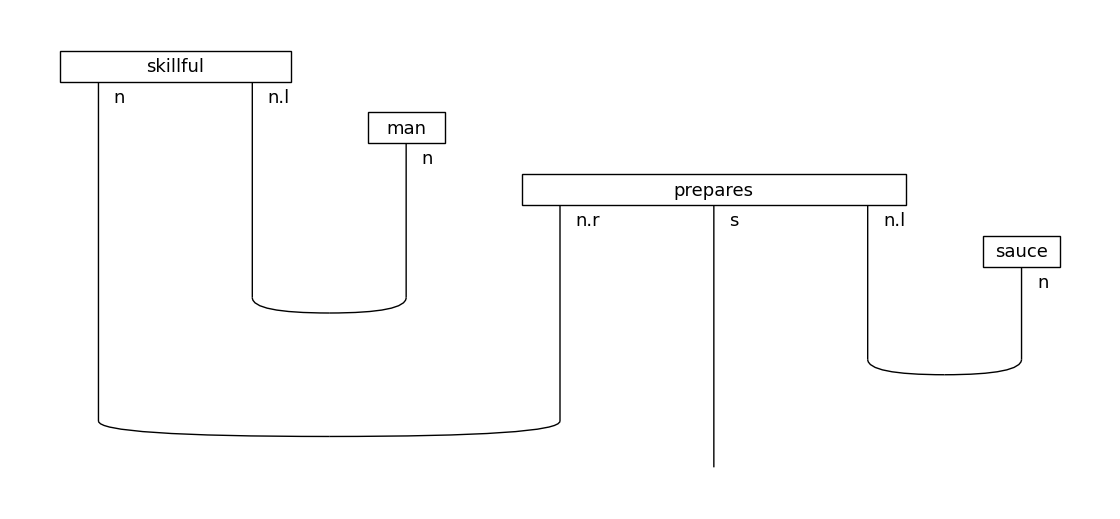

In [5]:
train_diagrams[0].draw(figsize=(11,5), fontsize=13)

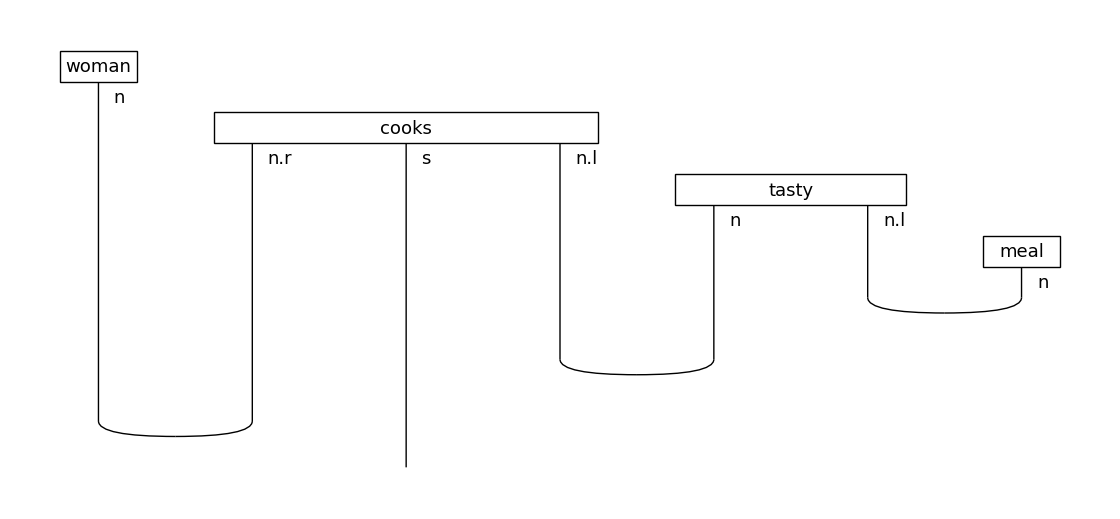

In [6]:
from lambeq import Rewriter

## Apply rewrite rules for sentences of both  training and testing dataset

#for the training features
rewriter = Rewriter(['prepositional_phrase', 'determiner','auxiliary','connector','coordination',
                     'object_rel_pronoun' , 'subject_rel_pronoun','postadverb' , 'preadverb','prepositional_phrase'])
r_train_diagrams = []

for diagram in train_diagrams:

  if diagram is not None:
      r_train_diagrams.append(rewriter(diagram))


        
r_train_diagrams[2].draw(figsize=(11,5), fontsize=13)

In [7]:
##for the testing features
r_test_diagrams = []

for diagram in test_diagrams:

  if diagram is not None:
      r_test_diagrams.append(rewriter(diagram))

In [8]:
##for the testing features
r_dev_diagrams = []

for diagram in raw_dev_diagrams:

  if diagram is not None:
      r_dev_diagrams.append(rewriter(diagram))

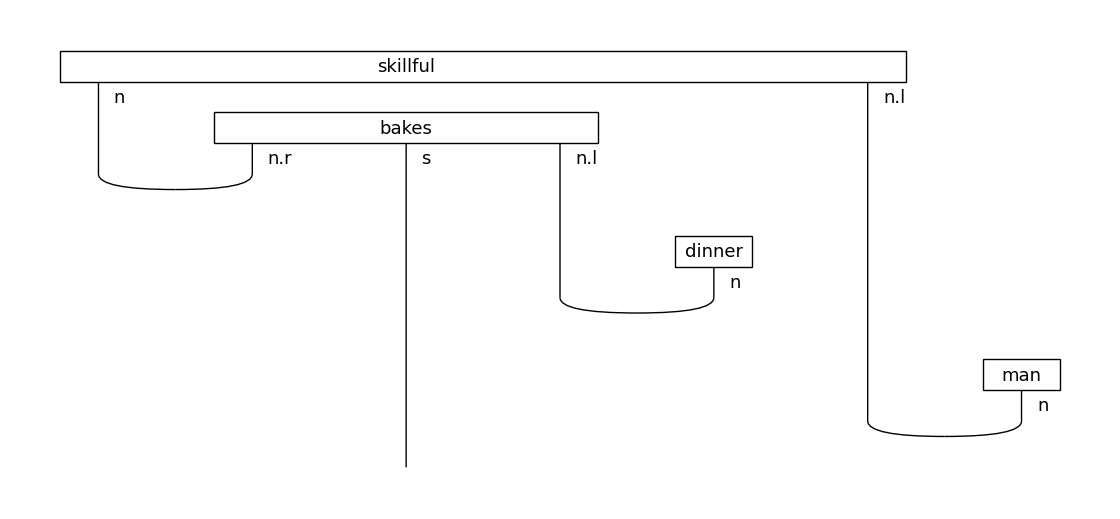

In [9]:
#normalizing the features

#from discopy.rigid import Diagram
n_train_diagrams = []
  
for diagram in r_train_diagrams:
     if diagram is not None:
       n_train_diagrams.append(diagram.normal_form())

n_test_diagrams = []

for diagram in r_test_diagrams:
     if diagram is not None:
       n_test_diagrams.append(diagram.normal_form())
    
n_dev_diagrams = []

for diagram in r_dev_diagrams:
     if diagram is not None:
       n_dev_diagrams.append(diagram.normal_form())
    
n_train_diagrams[1].draw(figsize=(11,5), fontsize=13)

In [10]:
#normalizing the labels
y_train = [
    label for (diagram, label)
    in zip(n_train_diagrams , train_labels )
    if diagram is not None]

y_test = [
    label for (diagram, label)
    in zip(n_test_diagrams, test_labels )
    if diagram is not None
]
y_dev=[
    label for (diagram, label)
    in zip(n_dev_diagrams, dev_labels )
    if diagram is not None 
]

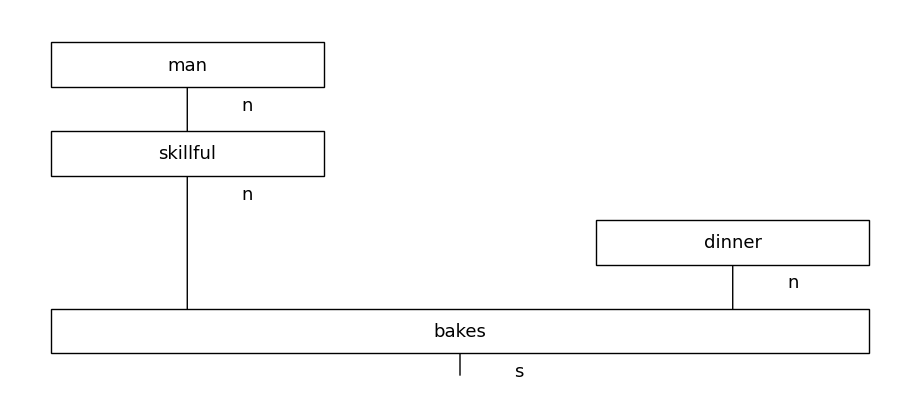

In [11]:
train_curried_diagram = []
curry_functor = Rewriter(['curry'])  

for diagram in n_train_diagrams:
     if diagram is not None:
        train_curried_diagram.append(curry_functor(diagram).normal_form())
      


train_curried_diagram[1].draw(figsize=(9,4), fontsize=13)

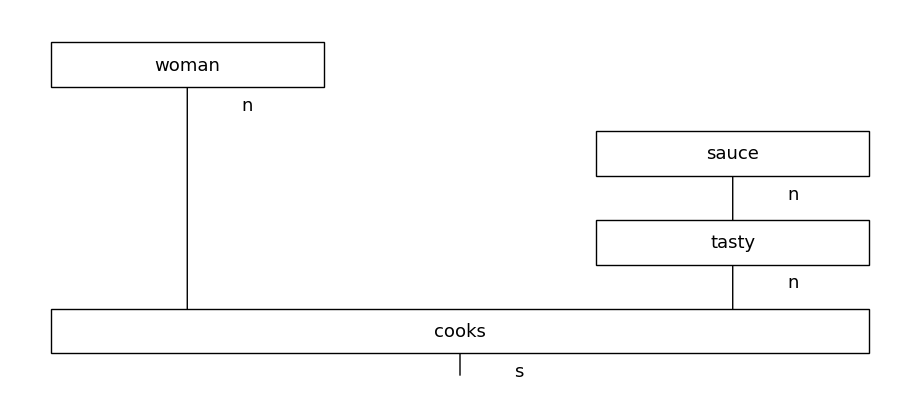

In [12]:
test_curried_diagram = []
curry_functor = Rewriter(['curry'])  

for diagram in n_test_diagrams:
     if diagram is not None:
        test_curried_diagram.append(curry_functor(diagram).normal_form())
      


test_curried_diagram[1].draw(figsize=(9,4), fontsize=13)

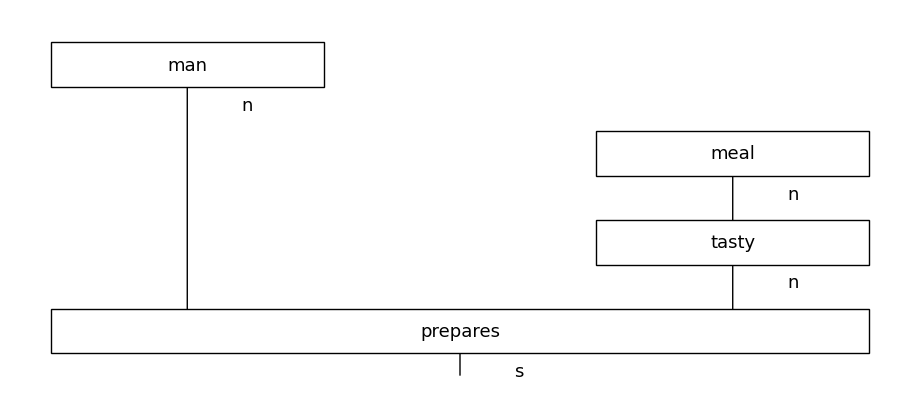

In [13]:
dev_curried_diagram = []
curry_functor = Rewriter(['curry'])  

for diagram in n_dev_diagrams:
     if diagram is not None:
        dev_curried_diagram.append(curry_functor(diagram).normal_form())
      


dev_curried_diagram[1].draw(figsize=(9,4), fontsize=13)

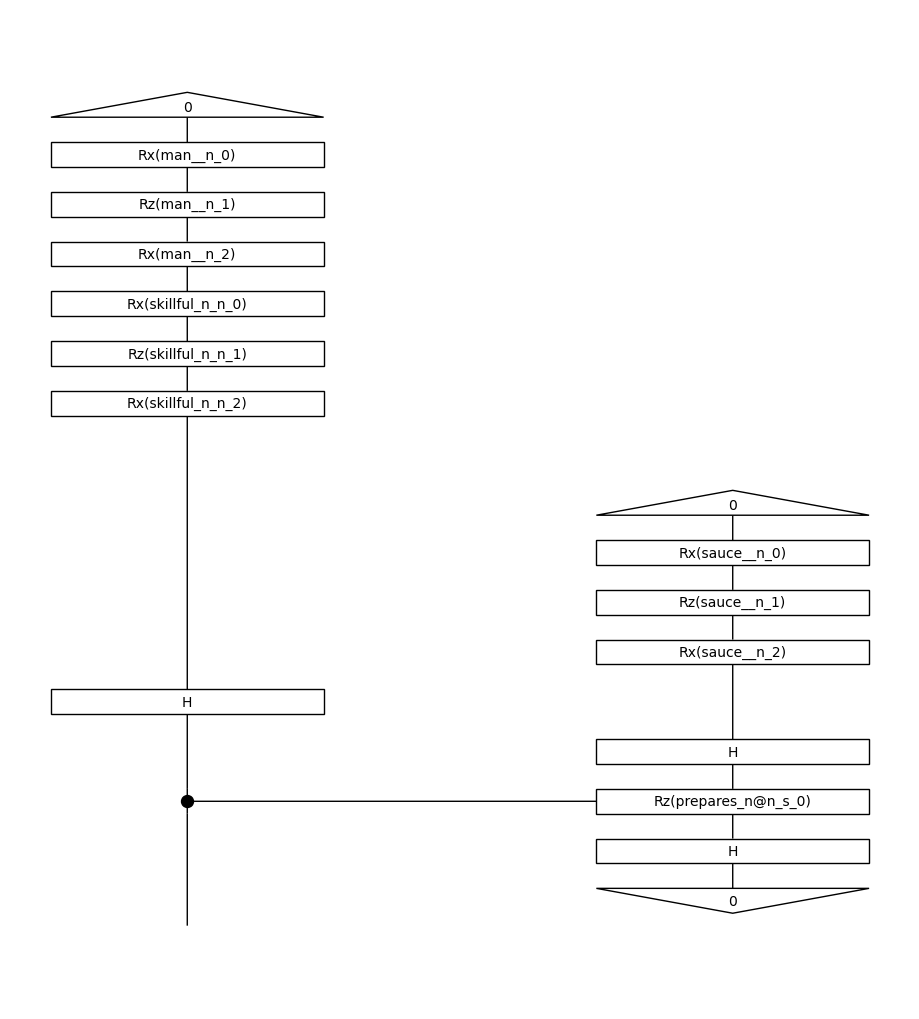

In [14]:
from lambeq import AtomicType, IQPAnsatz

ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=1, n_single_qubit_params=3)

train_circuits = [ansatz(diagram)  for diagram in train_curried_diagram if diagram is not None]
test_circuits =  [ansatz(diagram)  for diagram in test_curried_diagram if diagram is not None]
dev_circuits =  [ansatz(diagram)  for diagram in dev_curried_diagram if diagram is not None]
train_circuits[0].draw(figsize=(9, 10))

In [15]:
#IBMQBackend,NoIBMQAccountError,AerBackend,AerStateBackend,AerUnitaryBackend,IBMQEmulatorBackend,
from pytket.extensions.qiskit import AerBackend
from lambeq import TketModel

all_circuits = train_circuits + test_circuits + dev_circuits

backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 8192
}

model = TketModel.from_diagrams(all_circuits, backend_config=backend_config)

In [16]:
import numpy as np
##python numpy ValueError: operands could not be broadcast together with shapes

loss = lambda y_hat, y: -np.sum(y * np.log(y_hat)) / len(y)  # binary cross-entropy loss

acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting

In [17]:
from lambeq import Dataset

train_dataset = Dataset(
            train_circuits,
            y_train ,
            batch_size=BATCH_SIZE)

val_dataset = Dataset(dev_circuits, y_dev , shuffle=False)

In [18]:
from lambeq import QuantumTrainer, SPSAOptimizer


trainer = QuantumTrainer(
    model,
    loss_function=loss,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.08, 'c': 0.09 , 'A':0.01*EPOCHS},
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    verbose = 'text',
    seed=0
)

In [ ]:
trainer.fit(train_dataset, val_dataset, logging_step=10)

Epoch 1:    train/loss: 1.3693   valid/loss: 0.9781   train/acc: 0.5714   valid/acc: 0.5000
Epoch 10:   train/loss: 0.6358   valid/loss: 0.6971   train/acc: 0.6571   valid/acc: 0.6333
Epoch 20:   train/loss: 0.4620   valid/loss: 0.3197   train/acc: 0.9143   valid/acc: 0.8667
Epoch 30:   train/loss: 0.3136   valid/loss: 0.3172   train/acc: 0.8286   valid/acc: 0.8500
Epoch 40:   train/loss: 0.3145   valid/loss: 0.3139   train/acc: 0.9357   valid/acc: 0.8167
Epoch 50:   train/loss: 0.2954   valid/loss: 0.2603   train/acc: 0.9571   valid/acc: 0.9333
Epoch 60:   train/loss: 0.2871   valid/loss: 0.2472   train/acc: 0.9429   valid/acc: 0.9667
Epoch 70:   train/loss: 0.2353   valid/loss: 0.2537   train/acc: 0.9714   valid/acc: 0.9667
Epoch 80:   train/loss: 0.1762   valid/loss: 0.2057   train/acc: 0.9429   valid/acc: 0.9667


In [ ]:
import matplotlib.pyplot as plt

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(trainer.train_results['acc'], color=next(colours))
ax_tr.plot(trainer.val_costs, color=next(colours))
ax_br.plot(trainer.val_results['acc'], color=next(colours))

test_acc = acc(model(test_circuits), y_test)
print('Test accuracy:', test_acc)

In [ ]:
'''
def sentenceToCircit(sentence,parser,rewriter,curry_functor,ansatz):

    sentenceDiagram = parser.sentences2diagrams(train_data, suppress_exceptions=True)

    if sentenceDiagram is not None:
        r_diagram = rewriter(sentenceDiagram)
        n_diagram = r_diagram.normal_form()
        curried_diagram = curry_functor(n_diagram).normal_form()
        circuit = ansatz(curry_diagram)
        return circuit
    else:
        return None
'''

In [ ]:
def sentenceToCircit(sentence,rewriter,curry_functor,ansatz):


    # Parse the sentence and convert it into a string diagram
    parser = BobcatParser(verbose='suppress')
    diagram = parser.sentence2diagram(sentence)


    if diagram is not None:
        r_diagram = rewriter(diagram)
        n_diagram = r_diagram.normal_form()
        curried_diagram = curry_functor(n_diagram).normal_form()
        circuit = ansatz(curried_diagram)
        return circuit
    else:
        return None

In [ ]:
def result_label(prediction):
    food_score = prediction[0][0]
    it_score = prediction[0][1]
    label = 1

    if it_score > food_score:
        label = 0
        return label
    elif it_score <= food_score:
        return label

In [ ]:
print(f"woman prepares tasty dinner . 1 -->  {model.forward([test_circuits[0]])}")
print(f"woman cooks tasty sauce . 1 --> {model.forward([test_circuits[1]])}")
print(f"skillful woman prepares software . 0 --> {model.forward([test_circuits[2]])}")
print(f"skillful man prepares dinner . 1 --> {model.forward([test_circuits[3]])}")
print(f"skillful woman cooks sauce . 1 --> {model.forward([test_circuits[4]])}")
print(f"woman runs useful program . 0 --> {model.forward([test_circuits[5]])}")

In [ ]:
sentenceCircuit = sentenceToCircit("skillful woman prepares software .",rewriter,curry_functor,ansatz)

In [ ]:
prediction = model.forward([sentenceCircuit])
prediction

In [ ]:
result = prediction.tolist()

In [ ]:
print(result)

In [ ]:
if(result_label(prediction) == 0):
    print("the sentence topic is food/cooking")
else:
    print("the sentence topic is IT")

In [ ]:
print(model.forward([test_circuits[0]]))
print(model.forward([test_circuits[1]]))
print(model.forward([test_circuits[2]]))
print(model.forward([test_circuits[3]]))
print(model.forward([test_circuits[4]]))
print(model.forward([test_circuits[5]]))
print(model.forward([test_circuits[6]]))
print(model.forward([test_circuits[7]]))
print(model.forward([test_circuits[8]]))
print(model.forward([test_circuits[9]]))
print(model.forward([test_circuits[10]]))
print(model.forward([test_circuits[11]]))
print(model.forward([test_circuits[12]]))
print(model.forward([test_circuits[13]]))
print(model.forward([test_circuits[14]]))

In [ ]:
print(model.forward([train_circuits[0]]))
print(model.forward([train_circuits[1]]))
print(model.forward([train_circuits[2]]))
print(model.forward([train_circuits[3]]))
print(model.forward([train_circuits[4]]))
print(model.forward([train_circuits[5]]))
print(model.forward([train_circuits[6]]))
print(model.forward([train_circuits[7]]))
print(model.forward([train_circuits[8]]))
print(model.forward([train_circuits[9]]))
print(model.forward([train_circuits[10]]))
print(model.forward([train_circuits[11]]))
print(model.forward([train_circuits[12]]))
print(model.forward([train_circuits[13]]))
print(model.forward([train_circuits[14]]))


print(model.forward([train_circuits[15]]))
print(model.forward([train_circuits[16]]))
print(model.forward([train_circuits[17]]))
print(model.forward([train_circuits[18]]))
print(model.forward([train_circuits[19]]))
print(model.forward([train_circuits[20]]))
print(model.forward([train_circuits[21]]))
print(model.forward([train_circuits[22]]))
print(model.forward([train_circuits[23]]))
print(model.forward([train_circuits[24]]))
print(model.forward([train_circuits[25]]))
print(model.forward([train_circuits[26]]))
print(model.forward([train_circuits[27]]))
print(model.forward([train_circuits[28]]))
print(model.forward([train_circuits[29]]))